In [4]:
import os
print(os.getcwd())

import sys
sys.path.append(os.getcwd())

/net/tscratch/people/plgpiorczynskim/sae-diff-autointerpr


In [5]:
import torch

In [83]:
device = "cuda"
concept_embeddings_path = "sae_textual_inversion_sdxl_add_to_prompt_pooled_coco/mscoco_all_concept_embeddings.pt"
concept_embeddings = torch.load(concept_embeddings_path, map_location="cpu").to(device)

/net/tscratch/people/plgpiorczynskim/slurm_jobdir/1456711/tmp.t0002/ipykernel_750711/3162652143.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  concept_embeddings = torc

In [84]:
print(concept_embeddings.shape)

torch.Size([12833, 1280])


In [85]:
from src.vocab import get_vocabulary

concept_vocab = get_vocabulary('mscoco', vocabulary_size=-1)

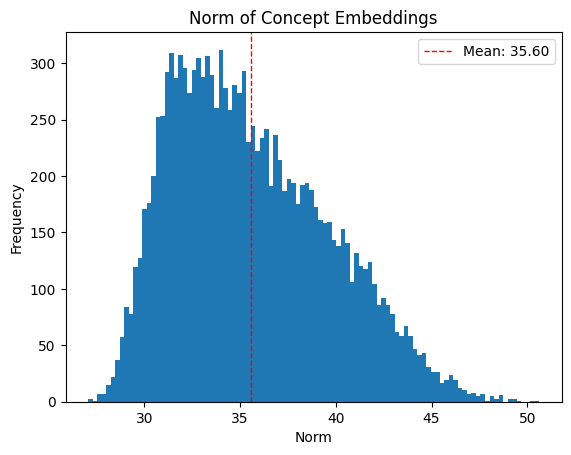

In [86]:
# What's the average norm of the concept embeddings?
import matplotlib.pyplot as plt

plt.hist(torch.norm(concept_embeddings, dim=1).cpu().numpy(), bins=100)
plt.title("Norm of Concept Embeddings")
plt.xlabel("Norm")
plt.ylabel("Frequency")
mean_norm = torch.mean(torch.norm(concept_embeddings, dim=1)).item()
plt.axvline(mean_norm, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_norm:.2f}')
plt.legend()
plt.show()

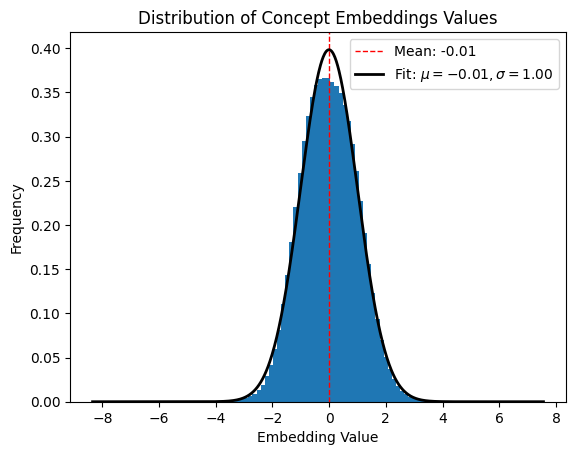

mean:  -0.005007558967918158
std:  1.0013893842697144
min:  -7.620147705078125
max:  6.836648941040039


In [87]:
# What's the distrbiution of the concept embeddings values?
plt.hist(concept_embeddings.cpu().numpy().flatten(), bins=100, density=True)
plt.title("Distribution of Concept Embeddings Values")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
mean_value = torch.mean(concept_embeddings).item()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f}')

# Fit a Gaussian to the distribution
from scipy.stats import norm
mu, std = norm.fit(concept_embeddings.cpu().numpy().flatten())
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Fit: $\mu={mu:.2f}, \sigma={std:.2f}$')
plt.legend()
plt.show()

print("mean: ", concept_embeddings.mean().item())
print("std: ", concept_embeddings.std().item())
print("min: ", concept_embeddings.min().item())
print("max: ", concept_embeddings.max().item())

In [88]:
concept_embeddings_normalized = concept_embeddings / concept_embeddings.norm(dim=1, keepdim=True)
cosine_similarities = concept_embeddings_normalized @ concept_embeddings_normalized.T

mask = torch.triu(cosine_similarities, diagonal=1).bool()
pairwise_cosine_similarities = cosine_similarities[mask]

print(cosine_similarities.size(0))
print("mean:", pairwise_cosine_similarities.mean().item())
print("std:", pairwise_cosine_similarities.std().item())
print("max:", pairwise_cosine_similarities.max().item())
print("min:", pairwise_cosine_similarities.min().item())


12833
mean: 0.5677216649055481
std: 0.06219199672341347
max: 0.9698143005371094
min: 0.21567073464393616


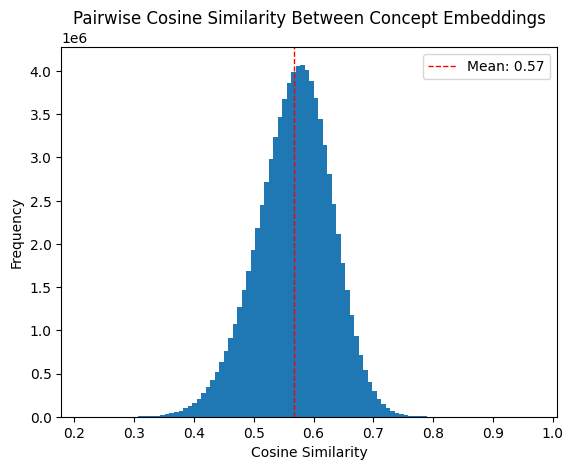

In [89]:

plt.hist(pairwise_cosine_similarities.cpu().numpy(), bins=100)
plt.title("Pairwise Cosine Similarity Between Concept Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
mean_sim =  pairwise_cosine_similarities.mean().item()
plt.axvline(mean_sim, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_sim:.2f}')
plt.legend()
plt.show()
plt.show()

In [127]:
# What's the average similarity with randomly initialized embedding?
import torch.nn as nn

projection_dim = 1280
std = 0.02
k = 8
learned_embed = torch.zeros(projection_dim, device=device)
nn.init.normal_(learned_embed, std=std)

learned_embed = learned_embed / learned_embed.norm(dim=0, keepdim=True)
concept_embeddings_normalized = concept_embeddings / concept_embeddings.norm(dim=1, keepdim=True)
cosine_similarities = learned_embed @ concept_embeddings_normalized.T

top_values, top_indices = cosine_similarities.topk(k)
top_concepts = [concept_vocab[i] for i in top_indices.tolist()]

print(cosine_similarities.size(0))
print("mean:", cosine_similarities.mean().item())
print("std:", cosine_similarities.std().item())
print("max:", cosine_similarities.max().item())
print("min:", cosine_similarities.min().item())

print()
print("top-k concepts:")
for value, concept in zip(top_values.tolist(), top_concepts):
	print(f"{concept}: {value:.4f}")

12833
mean: -0.007764555048197508
std: 0.018110888078808784
max: 0.07621655613183975
min: -0.07995899021625519

top-k concepts:
mimic: 0.0762
incoming: 0.0660
nave: 0.0625
detailing: 0.0623
compartment: 0.0584
bumps: 0.0572
requiring: 0.0563
scanner: 0.0559
